# Notebook PCA, t-SNE, and Classifying Sample Regions

**Description**: This notebook allows the user to perform (local and global) PCA, t-SNE, and barcode-level classification on a .csv file of gene expression data generated from SpaceRanger Output. To get this output, please use the spaceranger_dataextract notebook.

In [2]:
import csv
import gzip
import os
import scipy.io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.tree import export_graphviz

## 1. Extract Data From CSV:

Recall, this notebook is currently set up for aggregated clustering over 2 samples, so we set up two sets of data.

In [3]:
#Start from here, above code was to create csv
matrix = pd.read_csv("F8_37_human_mat.csv")

In [1]:
#matrix.loc[matrix["gene"] == "FASN"]

In [2]:
#matrix.loc[matrix["gene"] == "LDHA"]

In [3]:
#matrix2 = pd.read_csv("F8_38_human_outs/f838_human_filtered_matrix.csv")

## 2. Identifying Unexpressed Genes:

In [68]:
blank_list = []
for i in range(36601):
    #if i%100 == 0:
        #print(i)
    if matrix.iloc[i][3:].sum() == 0:
        blank_list.append(i)

In [7]:
print(len(blank_list))
blank_list[0:10]

14022


[0, 1, 2, 4, 5, 7, 10, 12, 13, 18]

In [8]:
#Ideas:
#Filter out zeros for all samples
#Summary statistics for each row
#Getting the top 5 most expressed genes for each coordinate and creating some kind of map or probability distro
#Apply Decision Trees, RFCs, or Gradient Boosting onto each sample using Dr. Erdogan's labels.
#Include all of this in paper

## 3. Creating Separate Tables for Genes and Expressions:

In [70]:
matrix.drop(columns=["feature_id", "feature_type"], inplace=True)
matrix.shape

(37733, 3525)

In [71]:
all_filtered = matrix.T
all_filtered.drop(columns=blank_list, axis=1, inplace=True)
all_filtered.head()

,3,6,8,9,11,14,15,16,17,19,...,37723,37724,37725,37726,37727,37728,37729,37730,37731,37732
gene,ENSG00000238009,ENSG00000241860,ENSG00000286448,ENSG00000236601,ENSG00000235146,LINC01409,FAM87B,LINC00115,LINC01128,FAM41C,...,ENSG00000275249,ENSG00000274792,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
AAACAAGTATCTCCCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACAATCTACTAGCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACAGCTTTCAGAAG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
matrix2.drop(columns=["feature_id", "feature_type"], inplace=True)
matrix2.shape

(37733, 3716)

In [ ]:
all_filtered2 = matrix2.T
all_filtered2.drop(columns=blank_list2, axis=1, inplace=True)
all_filtered2.head()

,3,6,8,9,11,14,15,16,17,19,...,37723,37724,37725,37726,37727,37728,37729,37730,37731,37732
gene,ENSG00000238009,ENSG00000241860,ENSG00000286448,ENSG00000236601,ENSG00000235146,LINC01409,FAM87B,LINC00115,LINC01128,FAM41C,...,ENSG00000275249,ENSG00000274792,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
AAACAAGTATCTCCCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACACCAATAACTGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGCTTTCAGAAG-1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 4. PCA:

In order to do any type of *local* PCA, one will need a region of barcodes/cells to define the area in which PCA will be performed on. To do this:

1. Open the correct sample in Loupe Browser (Loupe will need the corresponding cloupe file)
2. Select a region of barcodes/cells
3. Export this region as a CSV (you can give this region an informative name for clarity) -> This is the .csv file currently shown as `hotspot_region.csv` below

For global PCA on the entire tissue sample, no need to filter out the non-region cells as the entire sample is part of your dataset.

In [29]:
all_expr = matrix.drop(matrix.columns[[0,1,2]], axis=1)

In [30]:
all_expr

,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACCCGAACGAAATC-1,AAACCGGAAATGTTAA-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTCATGAAGTTG-1,...,TTGTGGTATAGGTATG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTGTAAATTC-1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37731,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
all_names = matrix[matrix.columns[[0,1,2]]]

In [32]:
all_names

,feature_id,gene,feature_type
0,ENSG00000243485,MIR1302-2HG,Gene Expression
1,ENSG00000237613,FAM138A,Gene Expression
2,ENSG00000186092,OR4F5,Gene Expression
3,ENSG00000238009,ENSG00000238009,Gene Expression
4,ENSG00000239945,ENSG00000239945,Gene Expression
...,...,...,...
37728,ENSG00000277836,ENSG00000277836,Gene Expression
37729,ENSG00000278633,ENSG00000278633,Gene Expression
37730,ENSG00000276017,ENSG00000276017,Gene Expression
37731,ENSG00000278817,ENSG00000278817,Gene Expression


In [33]:
filtered_expr = all_expr.drop(index=blank_list)
filtered_expr.head()

,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACCCGAACGAAATC-1,AAACCGGAAATGTTAA-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTCATGAAGTTG-1,...,TTGTGGTATAGGTATG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTGTAAATTC-1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
filtered_expr.iloc[:,0]

3        0
6        0
8        0
9        0
11       0
        ..
37728    0
37729    0
37730    0
37731    1
37732    0
Name: AAACAAGTATCTCCCA-1, Length: 23711, dtype: int64

In [35]:
filtered_names = all_names.drop(index=blank_list)
filtered_names.head()

,feature_id,gene,feature_type
3,ENSG00000238009,ENSG00000238009,Gene Expression
6,ENSG00000241860,ENSG00000241860,Gene Expression
8,ENSG00000286448,ENSG00000286448,Gene Expression
9,ENSG00000236601,ENSG00000236601,Gene Expression
11,ENSG00000235146,ENSG00000235146,Gene Expression


When doing global PCA, you can comment out the next few cells that deal with filtering out "non-region" barcodes.

In [36]:
hotspot_region = pd.read_csv("hotspot_region.csv")
hotspot_region.head()

,Barcode,Graph-based
0,AAACAGCTTTCAGAAG-1,Cluster 2
1,AAACAGGGTCTATATT-1,Cluster 2
2,AAACCGGGTAGGTACC-1,Cluster 2
3,AAACCGTTCGTCCAGG-1,Cluster 2
4,AAACCTCATGAAGTTG-1,Cluster 2


In [42]:
barcodes = list(hotspot_region["Barcode"])
print(len(barcodes))

583


In [39]:
filtered_expr.shape

(23711, 3524)

In [40]:
filtered_expr.drop(columns=[col for col in filtered_expr if col not in barcodes], inplace=True)

In [41]:
filtered_expr.shape

(23711, 583)

In [43]:
feature_mat = filtered_expr.T
#print(feature_mat.head())
feature_mat = np.array(feature_mat)

In [44]:
pca = PCA(n_components=4)
pca.fit(feature_mat)

PCA(n_components=4)

Cumulative Explained Variance:  [0.603, 0.79, 0.822, 0.839]


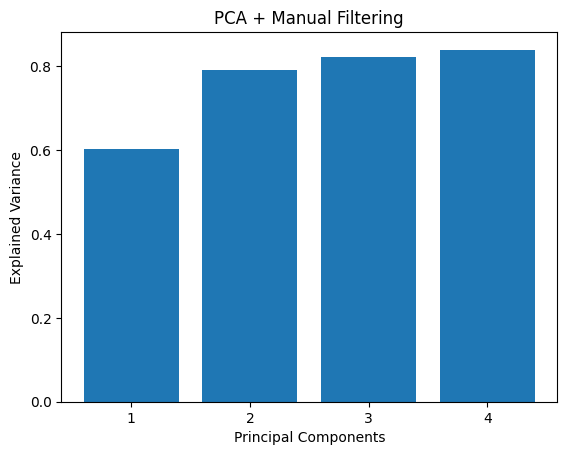

In [45]:
plt.bar(list(range(1, 5)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("PCA + Manual Filtering")
cumsum = []
for each in np.cumsum((pca.explained_variance_ratio_)):
    cumsum.append(float("{:.3f}".format(each)))
print("Cumulative Explained Variance: ", cumsum)
plt.rcParams["font.size"] = 16

In [54]:
sorted_genes1= np.argsort(pca.components_[0])
print(np.argsort(pca.components_[0]))

[23680 23677 13998 ... 12520  3481  3646]


In [57]:
filtered_names.iloc[sorted_genes1[:30]]

,feature_id,gene,feature_type
37702,ENSG00000198938,MT-CO3,Gene Expression
37699,ENSG00000198712,MT-CO2,Gene Expression
22687,ENSG00000229117,RPL41,Gene Expression
37698,ENSG00000198804,MT-CO1,Gene Expression
26808,ENSG00000137818,RPLP1,Gene Expression
33170,ENSG00000105372,RPS19,Gene Expression
35318,ENSG00000160182,TFF1,Gene Expression
29008,ENSG00000167526,RPL13,Gene Expression
37705,ENSG00000198886,MT-ND4,Gene Expression
37703,ENSG00000198840,MT-ND3,Gene Expression


In [61]:
sorted_genes2 = np.argsort(pca.components_[1])
filtered_names.iloc[sorted_genes2[:30]]

,feature_id,gene,feature_type
37702,ENSG00000198938,MT-CO3,Gene Expression
37698,ENSG00000198804,MT-CO1,Gene Expression
37699,ENSG00000198712,MT-CO2,Gene Expression
37705,ENSG00000198886,MT-ND4,Gene Expression
37701,ENSG00000198899,MT-ATP6,Gene Expression
37703,ENSG00000198840,MT-ND3,Gene Expression
37708,ENSG00000198727,MT-CYB,Gene Expression
37696,ENSG00000198888,MT-ND1,Gene Expression
37697,ENSG00000198763,MT-ND2,Gene Expression
35318,ENSG00000160182,TFF1,Gene Expression


## 5a. Summary Statistics and Analysis:

In [ ]:
expr_stats = filtered_expr.T.describe()


In [14]:
expr_stats.columns = all_filtered.columns
expr_stats.head(10)


gene,AL627309.1,AL627309.5,AP006222.2,AL732372.1,AC114498.1,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,...,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC136612.1,AC136616.1,AC007325.4
count,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,...,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000
mean,0.008518,0.009086,0.002839,0.006246,0.000568,0.049972,0.000568,0.100227,0.016184,0.002555,...,0.100511,0.021863,0.055934,0.009654,0.004827,0.005395,0.000852,0.000568,0.018739,0.087166
std,0.091912,0.094899,0.053217,0.082324,0.033700,0.225602,0.023826,0.326619,0.130624,0.050493,...,0.324350,0.148185,0.234718,0.097791,0.069317,0.073260,0.029177,0.023826,0.139748,0.297791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000


In [21]:
expr_stats.loc[filtered_names["gene"] == "TFF3"]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
TFF3_expr = filtered_expr.loc[filtered_names["gene"] == "TFF3"]
TFF3_expr

In [ ]:
'''# the histogram of the data
n, bins, patches = plt.hist(TFF3_expr, bins=20, density=True, facecolor='g', alpha=0.75)


plt.xlabel('UMI Counts')
plt.ylabel('Probability')
plt.title('Histogram of TFF3')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 180)
plt.ylim(0, 0.03)
plt.grid(True)
plt.show()'''

## 5b. An Extra Global PCA Example (no different than earlier):

In [15]:
#First, we STANDARDIZE (zero mean and unit std. dev):
feature_mat = filtered_expr.T
print(feature_mat.head())
feature_mat = np.array(feature_mat)
print(feature_mat)
'''scaler = StandardScaler()
scaler.fit(feature_mat)
print(scaler.mean_[2])
scaled_data = scaler.transform(feature_mat)'''

                    3      6      8      9      11     14     15     16     \
AAACAAGTATCTCCCA-1      0      0      0      0      0      0      0      0   
AAACAATCTACTAGCA-1      0      0      0      0      0      0      0      0   
AAACAGAGCGACTCCT-1      0      0      0      0      0      0      0      0   
AAACAGCTTTCAGAAG-1      0      0      0      0      0      0      0      0   
AAACAGGGTCTATATT-1      0      0      0      0      0      0      0      0   

                    17     18     ...  36573  36574  36575  36579  36580  \
AAACAAGTATCTCCCA-1      0      0  ...      1      0      0      0      0   
AAACAATCTACTAGCA-1      0      0  ...      0      0      0      0      0   
AAACAGAGCGACTCCT-1      0      0  ...      0      0      0      0      0   
AAACAGCTTTCAGAAG-1      0      0  ...      0      0      0      0      0   
AAACAGGGTCTATATT-1      0      0  ...      0      0      0      0      0   

                    36581  36584  36592  36593  36599  
AAACAAGTATCTCCCA-1

'scaler = StandardScaler()\nscaler.fit(feature_mat)\nprint(scaler.mean_[2])\nscaled_data = scaler.transform(feature_mat)'

In [17]:
#Trying Normalizing instead of standardizing
norm = Normalizer()
norm.fit(feature_mat)
norm_data = norm.transform(feature_mat)

In [107]:
scaled_data[0:10]

NameError: name 'scaled_data' is not defined

In [16]:
pca = PCA(n_components=4)
pca.fit(feature_mat)

PCA(n_components=4)

Cumulative Explained Variance:  [0.781, 0.88, 0.899, 0.911]


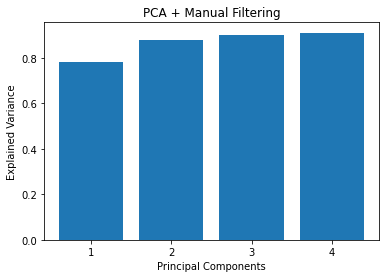

In [17]:
plt.bar(list(range(1, 5)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("PCA + Manual Filtering")
cumsum = []
for each in np.cumsum((pca.explained_variance_ratio_)):
    cumsum.append(float("{:.3f}".format(each)))
print("Cumulative Explained Variance: ", cumsum)
plt.rcParams["font.size"] = 16

In [18]:
print(np.argmax(pca.components_[0]))

13535


In [19]:
filtered_expr.iloc[13535]

AAACAAGTATCTCCCA-1    389
AAACAATCTACTAGCA-1    465
AAACAGAGCGACTCCT-1     62
AAACAGCTTTCAGAAG-1    526
AAACAGGGTCTATATT-1    383
                     ... 
TTGTTGTGTGTCAAGA-1     65
TTGTTTCACATCCAGG-1    530
TTGTTTCATTAGTCTA-1    296
TTGTTTCCATACAACT-1    345
TTGTTTGTGTAAATTC-1    134
Name: 21902, Length: 3522, dtype: int64

In [20]:
filtered_names.loc[21902]

feature_id      ENSG00000229117
gene                      RPL41
feature_type    Gene Expression
Name: 21902, dtype: object

## 6. TSNE:

In [21]:
projected = pca.transform(feature_mat)
print(len(projected))

3522


In [22]:
tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
embedded = tsne.fit_transform(projected)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [23]:
print(embedded)
print(embedded.T)

[[-22.887768   16.138916 ]
 [-54.59031    22.7679   ]
 [ 51.124084   19.455606 ]
 ...
 [ -5.0025234  32.445377 ]
 [-25.968054   31.507772 ]
 [ 10.215057  -54.65688  ]]
[[-22.887768  -54.59031    51.124084  ...  -5.0025234 -25.968054
   10.215057 ]
 [ 16.138916   22.7679     19.455606  ...  32.445377   31.507772
  -54.65688  ]]


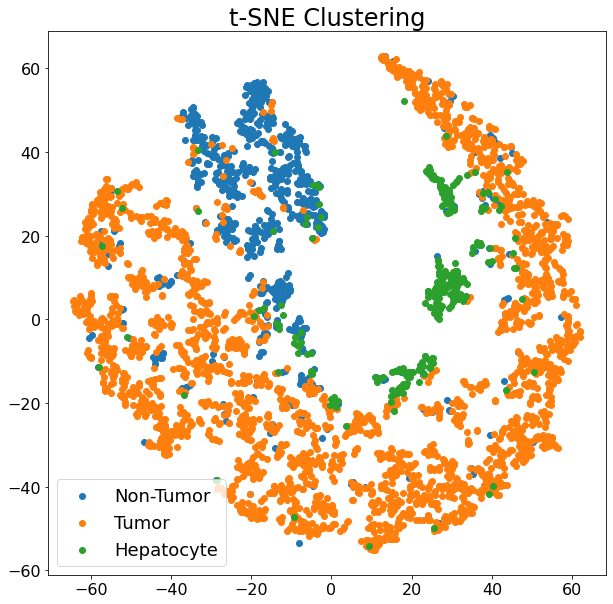

In [28]:
two_components = np.hstack((embedded, tumor.reshape(-1,1)))
two_components = pd.DataFrame(data=two_components)
two_components.columns = ["c1", "c2", "label"]

label_groups = two_components.groupby("label")

plt.figure(figsize=(10, 10))
for label, group in label_groups:
    plt.scatter(group["c1"], group["c2"], marker="o", label=label)

plt.legend(labels=["Non-Tumor", "Tumor", "Hepatocyte"], fontsize=18)
plt.title("t-SNE Clustering", fontdict={"fontsize": 24})
plt.show()

#plt.scatter(embedded.T[0], embedded.T[1]) #Add class labels from segmentation

## 7a. Classification:

If you want to classify a tissue sample into specific regions based on their gene expression data, you will first need to define different regions you would like to classify. This can be done using the Loupe method explained in **Part 4: PCA** of this notebook. The analysis below is on classifying a tissue sample into tumor, non-tumor, and hepatocyte regions.

Methods Used:
1. Support-Vector Machine Classifier
2. Decision Tree Classifier
3. Random Forest Classifier

In [25]:
tumor = pd.read_csv("Tumor.csv")
non_tumor = pd.read_csv("Non-Tumor.csv")
hepatocyte = pd.read_csv("Hepatocyte.csv")

In [26]:
tumor = np.array(tumor["Tumor"])
print(tumor)


[ 1.  1.  1. ... nan nan  1.]


In [27]:
for i in range(3522):
    if np.isnan(tumor[i]):
        tumor[i] = 0
print((tumor==1).sum())
for i in range(3522):
    if np.isnan(non_tumor["Non-Tumor"][i]) == False:
        tumor[i] = 0
print((tumor==1).sum())

for j in range(3522):
    if np.isnan(hepatocyte["Hepatocyte"][j]) == False:
        tumor[j] = 2
print((tumor==1).sum())
print((tumor==2).sum())
print(tumor[0:20])

2571
2532
2529
281
[1. 1. 1. 0. 0. 1. 2. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


In [29]:
sc = StandardScaler()
no = Normalizer()

In [30]:
scaled_train = sc.fit_transform(projected)
print(scaled_train)
normalized_train = no.fit_transform(projected)
print(normalized_train)

[[ 0.93811728  0.36109474  0.54273543  0.18698935]
 [ 1.60676671 -2.00024485 -1.10160058 -1.18967684]
 [-1.06758532  0.17395594 -0.11684745 -0.01206202]
 ...
 [ 1.02163516  2.69483307 -0.49914913  1.28344976]
 [ 1.38053766  0.38526521  0.01426075 -1.59310526]
 [-0.51831721 -0.33029945 -0.65961558 -0.36175697]]
[[ 0.98640611  0.13544598  0.08999053  0.02364472]
 [ 0.90653293 -0.40258749 -0.09800876 -0.08071949]
 [-0.99816578  0.05802106 -0.01722778 -0.00135625]
 ...
 [ 0.72277808  0.68012285 -0.05568644  0.10919599]
 [ 0.98572535  0.09813271  0.00160568 -0.13679518]
 [-0.95389757 -0.21685045 -0.19142868 -0.08006481]]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, tumor, test_size=.2, random_state=0, shuffle=True, stratify=tumor)
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(projected, tumor, test_size=.2, random_state=0, shuffle=True, stratify=tumor)

In [32]:
model = LogisticRegression(random_state=0)

In [33]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [34]:
model.score(X_test, y_test)

0.9134751773049645

In [35]:
rfc_model = rfc(random_state=0)

In [36]:
rfc_model.fit(X_train_us, y_train_us)

RandomForestClassifier(random_state=0)

In [37]:
rfc_model.score(X_test_us, y_test_us)

0.9333333333333333

In [38]:
svc_model = svc(random_state=0)

In [39]:
svc_model.fit(X_train, y_train)

SVC(random_state=0)

In [40]:
svc_model.score(X_test,y_test)

0.9319148936170213

In [46]:
dtc_model = dtc(random_state=0, max_depth=3)

In [47]:
dtc_model.fit(X_train_us, y_train_us)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [48]:
dtc_model.score(X_test_us, y_test_us)

0.8567375886524823

[Text(0.5, 0.875, 'PCA2 <= 106.192\ngini = 0.437\nsamples = 2817\nvalue = [569, 2023, 225]'),
 Text(0.25, 0.625, 'PCA4 <= -71.689\ngini = 0.328\nsamples = 2463\nvalue = [273, 1990, 200]'),
 Text(0.125, 0.375, 'PCA1 <= 171.976\ngini = 0.299\nsamples = 120\nvalue = [98, 22, 0]'),
 Text(0.0625, 0.125, 'gini = 0.48\nsamples = 20\nvalue = [8, 12, 0]'),
 Text(0.1875, 0.125, 'gini = 0.18\nsamples = 100\nvalue = [90, 10, 0]'),
 Text(0.375, 0.375, 'PCA3 <= -37.368\ngini = 0.282\nsamples = 2343\nvalue = [175, 1968, 200]'),
 Text(0.3125, 0.125, 'gini = 0.543\nsamples = 663\nvalue = [78, 401, 184]'),
 Text(0.4375, 0.125, 'gini = 0.127\nsamples = 1680\nvalue = [97, 1567, 16]'),
 Text(0.75, 0.625, 'PCA4 <= 9.559\ngini = 0.287\nsamples = 354\nvalue = [296, 33, 25]'),
 Text(0.625, 0.375, 'PCA1 <= 226.711\ngini = 0.094\nsamples = 203\nvalue = [193, 1, 9]'),
 Text(0.5625, 0.125, 'gini = 0.375\nsamples = 28\nvalue = [21, 0, 7]'),
 Text(0.6875, 0.125, 'gini = 0.034\nsamples = 175\nvalue = [172, 1, 2]'),
 

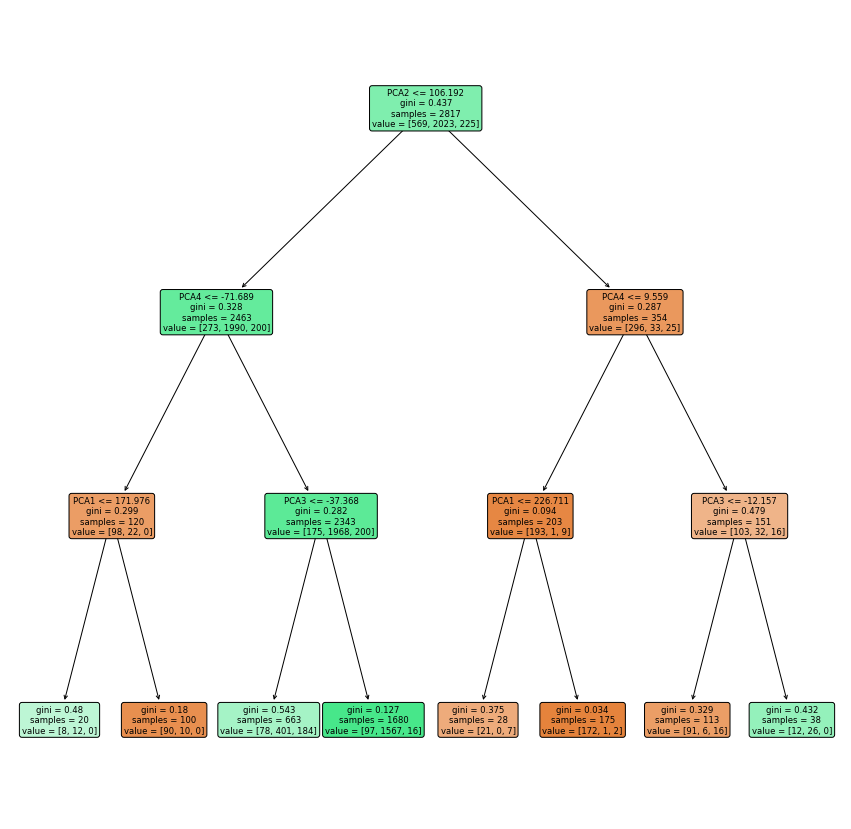

In [59]:
from sklearn import tree
plt.figure(figsize=(15,15))
tree.plot_tree(dtc_model,
                feature_names=["PCA1", "PCA2", "PCA3", "PCA4"],
                filled=True,
                rounded=True,
              fontsize=8.5)

[Text(0.6618631595254958, 0.975, 'PCA1 <= 434.957\ngini = 0.436\nsamples = 1784\nvalue = [565, 2026, 226]'),
 Text(0.40587929355524077, 0.925, 'PCA3 <= -37.368\ngini = 0.324\nsamples = 1396\nvalue = [200, 1802, 220]'),
 Text(0.19281161473087818, 0.875, 'PCA4 <= 23.215\ngini = 0.589\nsamples = 355\nvalue = [68, 285, 201]'),
 Text(0.1051699716713881, 0.825, 'PCA2 <= -22.408\ngini = 0.385\nsamples = 226\nvalue = [48, 268, 34]'),
 Text(0.03541076487252125, 0.775, 'PCA1 <= -233.945\ngini = 0.087\nsamples = 143\nvalue = [3, 213, 7]'),
 Text(0.0113314447592068, 0.725, 'PCA4 <= -8.281\ngini = 0.432\nsamples = 11\nvalue = [0, 13, 6]'),
 Text(0.0056657223796034, 0.675, 'gini = 0.0\nsamples = 8\nvalue = [0, 11, 0]'),
 Text(0.0169971671388102, 0.675, 'PCA4 <= -0.166\ngini = 0.375\nsamples = 3\nvalue = [0, 2, 6]'),
 Text(0.0113314447592068, 0.625, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 6]'),
 Text(0.0226628895184136, 0.625, 'gini = 0.0\nsamples = 1\nvalue = [0, 2, 0]'),
 Text(0.059490084985835696

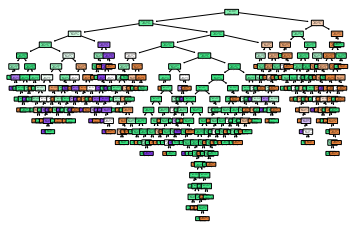

In [48]:
from sklearn import tree
tree.plot_tree(rfc_model.estimators_[0],
                feature_names=["PCA1", "PCA2", "PCA3", "PCA4"],
                filled=True,
                rounded=True)

In [46]:
os.system('dot -Tpng tree.dot -o tree.png')

sh: dot: command not found


32512

In [39]:
from sklearn.metrics import accuracy_score,plot_confusion_matrix, classification_report

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


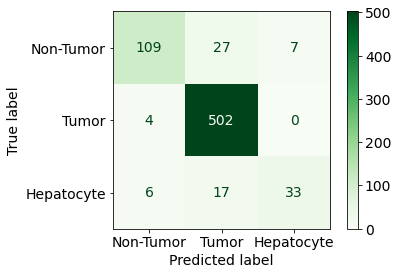

In [41]:
plt.rcParams["font.size"] = 14
plot_confusion_matrix(model,X_test,y_test, display_labels=["Non-Tumor", "Tumor", "Hepatocyte"], cmap="Greens")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


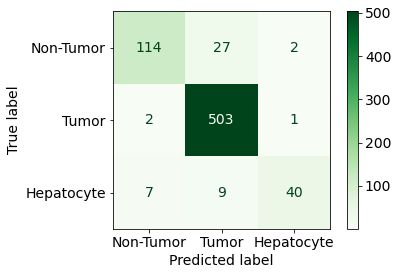

In [42]:
plot_confusion_matrix(svc_model,X_test,y_test, display_labels=["Non-Tumor", "Tumor", "Hepatocyte"], cmap="Greens")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


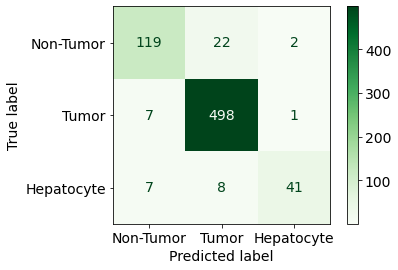

In [43]:
plot_confusion_matrix(rfc_model,X_test_us,y_test_us, display_labels=["Non-Tumor", "Tumor", "Hepatocyte"], cmap="Greens")

## 7b. Classification Excluding Hepatocyte:

In [45]:
tumor = pd.read_csv("Tumor.csv")
non_tumor = pd.read_csv("Non-Tumor.csv")
hepatocyte = pd.read_csv("Hepatocyte.csv")
tumor = np.array(tumor["Tumor"])

In [46]:
tumor = np.array(tumor)
for i in range(3522):
    if np.isnan(tumor[i]):
        tumor[i] = 0
print((tumor==1).sum())
for i in range(3522):
    if np.isnan(non_tumor["Non-Tumor"][i]) == False:
        tumor[i] = 0
print((tumor==1).sum())

2571
2532


In [47]:
sc = StandardScaler()
no = Normalizer()

In [48]:
scaled_train = sc.fit_transform(projected)
print(scaled_train)
normalized_train = no.fit_transform(projected)
print(normalized_train)

[[ 0.93811728  0.36109474  0.54273543  0.18698935]
 [ 1.60676671 -2.00024485 -1.10160058 -1.18967684]
 [-1.06758532  0.17395594 -0.11684745 -0.01206202]
 ...
 [ 1.02163516  2.69483307 -0.49914913  1.28344976]
 [ 1.38053766  0.38526521  0.01426075 -1.59310526]
 [-0.51831721 -0.33029945 -0.65961558 -0.36175697]]
[[ 0.98640611  0.13544598  0.08999053  0.02364472]
 [ 0.90653293 -0.40258749 -0.09800876 -0.08071949]
 [-0.99816578  0.05802106 -0.01722778 -0.00135625]
 ...
 [ 0.72277808  0.68012285 -0.05568644  0.10919599]
 [ 0.98572535  0.09813271  0.00160568 -0.13679518]
 [-0.95389757 -0.21685045 -0.19142868 -0.08006481]]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, tumor, test_size=.2, random_state=0, shuffle=True, stratify=tumor)
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(projected, tumor, test_size=.2, random_state=0, shuffle=True, stratify=tumor)

In [50]:
log_reg = LogisticRegression(random_state=0)

In [51]:
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [52]:
log_reg.score(X_test, y_test)

0.8680851063829788

In [53]:
rfc2= rfc(random_state=0)

In [54]:
rfc2.fit(X_train_us, y_train_us)

RandomForestClassifier(random_state=0)

In [55]:
rfc2.score(X_test_us, y_test_us)

0.9404255319148936

In [56]:
svc2 = svc(random_state=0)

In [57]:
svc2.fit(X_train, y_train)

SVC(random_state=0)

In [58]:
svc2.score(X_test, y_test)

0.9347517730496454

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


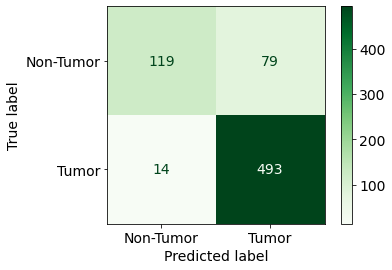

In [59]:
plot_confusion_matrix(log_reg,X_test,y_test, display_labels=["Non-Tumor", "Tumor"], cmap="Greens")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


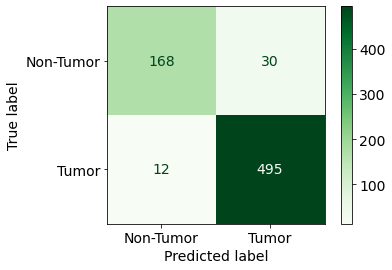

In [60]:
plot_confusion_matrix(rfc2,X_test_us,y_test_us, display_labels=["Non-Tumor", "Tumor"], cmap="Greens")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


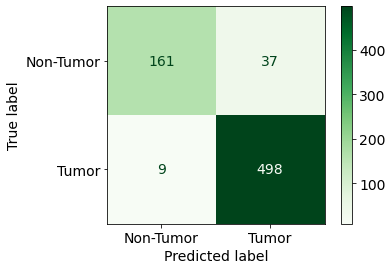

In [61]:
plot_confusion_matrix(svc2,X_test,y_test, display_labels=["Non-Tumor", "Tumor"], cmap="Greens")